Breast Cancer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [2]:
brca = cptac.Brca()
proteomics = brca.get_proteomics()
clinical = brca.get_clinical()

## Step 2: Data Cleaning and Choosing Attributes to A/B Test
First, we will drop columns we are not interested in, and then make each of the columns binary

In [3]:
cols_to_drop = ['Patient_ID', 'Replicate_Measurement_IDs', 
                'Sample_Tumor_Normal', 'Human.Readable.Label', 'Gender',
                'Experiment', 'Channel', 'Ischemia.Decade', 'QC.status']

annotations = clinical.copy()
annotations = annotations.drop(cols_to_drop, axis=1)

In [4]:
# Minor Data Cleaning

things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown', 
                     'Unknown Tumor Status', 'Not specified']

for col in annotations.columns:
    annotations[col] = annotations[col].replace(things_to_replace, np.nan)
    

In [5]:
annotations['Age.in.Month'] = pd.to_numeric(annotations['Age.in.Month'])

In [6]:
IHC_map = {'4+':'Four','3+':'Three', '2+':'Two', '1+':'One', '0':'Zero'}

annotations['PR.IHC.Score'] = bf.binarizeCategorical(annotations, 'PR.IHC.Score', IHC_map)
annotations['ER.IHC.Score'] = bf.binarizeCategorical(annotations, 'ER.IHC.Score', IHC_map)

In [7]:
for col in annotations.columns:
    if np.issubdtype(annotations[col].dtype, np.number):
        mean = annotations[col].mean()
        annotations[col]= bf.binarizeCutOff(annotations, col, mean,
                                            "Above_Mean("+str(round(mean, 2))+")",
                                            "Below_Mean("+str(round(mean, 2))+")")

In [8]:
for col in annotations.columns:
    print(col)
    print(annotations[col].value_counts())
    print('\n')

Age.in.Month
Above_Mean(727.64)    54
Below_Mean(727.64)    51
Name: Age.in.Month, dtype: int64


Race
white                        78
asian                        19
black.or.african.american    14
hispanic.or.latino            4
Name: Race, dtype: int64


Stage
Stage IIA     50
Stage IIIA    22
Stage IIB     20
Stage IA       4
Stage III      4
Stage IIIC     4
Stage IIIB     3
Name: Stage, dtype: int64


PAM50
LumA      57
Basal     29
LumB      17
Her2      14
Normal     5
Name: PAM50, dtype: int64


NMF.v2.1
C3    33
C2    32
C1    26
C4    25
Name: NMF.v2.1, dtype: int64


ER
positive    78
negative    37
Name: ER, dtype: int64


PR
positive    68
negative    47
Name: PR, dtype: int64


ER.IHC.Score
Three    47
Zero     28
Two       9
One       2
Four      1
Name: ER.IHC.Score, dtype: int64


PR.IHC.Score
Three    42
Zero     38
Two       7
Four      1
One       1
Name: PR.IHC.Score, dtype: int64


Coring.or.Excision
excision    95
coring      10
Name: Coring.or.Excision, dtype: 

In [9]:
annotations = deva.binarize_annotations(annotations)

## Step 3: Perform Outlier Analysis
Using the Blacksheep-outliers package, deva, we will create two tables: one of all the significant up-regulated genes per patient (which we will call outliers), and one of the q-values for significantly enriched genes based on our binarized clinical attributes (which we will call qvalues).

In [10]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(), 
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False)

09/24/2019 13:47:55:WARNING:No rows tested for fisherFDR_Age.in.Month_Above_Mean(727.64)
09/24/2019 13:47:55:WARNING:No rows tested for fisherFDR_Age.in.Month_Below_Mean(727.64)
09/24/2019 13:47:55:WARNING:No rows tested for fisherFDR_Race_white_white
09/24/2019 13:47:55:WARNING:No rows tested for fisherFDR_Race_white_not-white
09/24/2019 13:47:55:WARNING:No rows tested for fisherFDR_Race_asian_not-asian
09/24/2019 13:47:56:WARNING:No rows tested for fisherFDR_Race_black.or.african.american_not-black.or.african.american
09/24/2019 13:47:56:WARNING:No rows tested for fisherFDR_Race_hispanic.or.latino_not-hispanic.or.latino
09/24/2019 13:47:57:WARNING:No rows tested for fisherFDR_Stage_Stage IIA_not-Stage IIA
09/24/2019 13:47:57:WARNING:No rows tested for fisherFDR_Stage_Stage IIA_Stage IIA
09/24/2019 13:47:57:WARNING:No rows tested for fisherFDR_Stage_Stage IIIA_not-Stage IIIA
09/24/2019 13:47:57:WARNING:No rows tested for fisherFDR_Stage_Stage IIB_not-Stage IIB
09/24/2019 13:47:58:WARN

In [11]:
length = int(len(outliers.df.columns) / 2)
temp_outliers = outliers.df.transpose()
only_outliers_up = temp_outliers[:length]
outliers_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_up_dict[key] = value

## Step 4: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [12]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
for col in qvalues.df.columns:
    sig_col = bf.significantEnrichments(qvalues.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = qvalues.df.drop(col, axis=1)

In [13]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(set(col.index.get_level_values('Name')))
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes

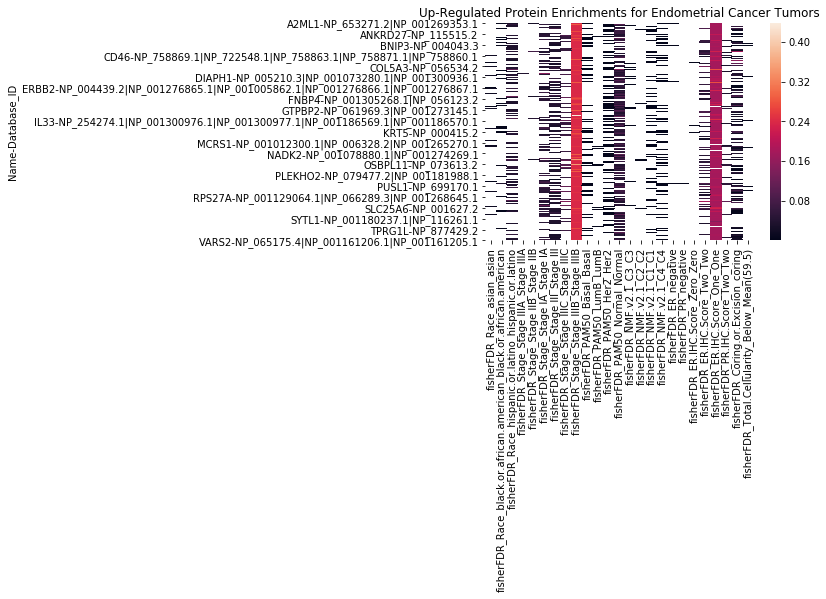

In [14]:
#Simple visualization
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Endometrial Cancer Tumors')
plt.show()

## Step 5: Perform Gene Set Enrichment Analysis

Part A: Up-regulated Genes

In [15]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(set(col.index.get_level_values('Name')))
    print('Gene List:', gene_name_list, '\n')
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/endo')
    gsea_up[col_name] = enrichment

Race_asian_asian
Gene List: ['CLCA2', 'DDX58', 'KIF21B', 'COL6A6', 'PRG2', 'CD55', 'FAR1', 'SLC12A2', 'RBM23', 'STARD3', 'GRB7', 'MAP3K9', 'GOLGA2', 'MIEN1', 'CKAP4', 'EPX', 'MLK4', 'ERBB2'] 



2019-09-24 13:48:22,267 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:22:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Race_black.or.african.american_black.or.african.american
Gene List: ['TP53', 'CTPS1', 'PADI4', 'RPL7L1', 'KIF1A', 'FMR1', 'AZU1', 'POLD2', 'PRTN3', 'DLGAP5', 'BPI', 'ARHGEF2', 'DDX18', 'A2ML1', 'ADD2', 'ASUN', 'KRT81', 'ZBP1', 'GDI2', 'KCTD9', 'SNIP1', 'GLS', 'KRT16'] 



2019-09-24 13:48:24,922 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:24:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Race_hispanic.or.latino_hispanic.or.latino
Gene List: ['SMPDL3A', 'TIMM8B', 'ACSL1', 'DLAT', 'MECR', 'DNAJA3', 'MCRIP2', 'CMA1', 'PDHX', 'PRR15L', 'NDE1', 'CTSO', 'NDUFS2', 'RIDA', 'CHDH', 'GGA2', 'MOCS2', 'PTPMT1', 'CPT2', 'CEP44', 'NDUFV2', 'NDUFA12', 'C2CD5', 'MERTK', 'SNX16', 'FAHD1', 'COQ6', 'PLCZ1', 'C8orf59', 'LCMT1', 'PRKCQ', 'UQCRC1', 'C14orf159', 'HOXB4', 'BPHL', 'BCAR3', 'DUT', 'HIRIP3', 'C15orf48', 'RRN3', 'CD2BP2', 'USP7', 'MPG', 'ACAD8', 'NLRX1', 'FIS1', 'NDUFA13', 'ECI1', 'NDUFC1', 'APOBR', 'NAGLU', 'KRT36', 'ABAT', 'GCOM1', 'GSTM4', 'UQCRC2', 'HADH', 'NDUFS5', 'TRIM8', 'NDUFS3', 'DCTPP1', 'PGP', 'DLD', 'GSPT1', 'CPNE3', 'SCO1', 'CEACAM6', 'ARL6IP1', 'ZNF185', 'GALM', 'GATM', 'PLA2G16', 'LETM1', 'DECR2', 'NDUFA11', 'SEPHS2', 'RHOT2', 'PARN', 'UQCRFS1', 'UQCRB', 'PPIF'] 

Stage_Stage_IIB_Stage_IIB
Gene List: ['NME4', 'IARS2', 'A2ML1', 'FDFT1'] 



2019-09-24 13:48:31,660 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:31:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Stage_Stage_IA_Stage_IA
Gene List: ['SECISBP2L', 'KIF3C', 'SIX5', 'SCRN1', 'AP2A1', 'SEC14L2', 'CBX3', 'EPN1', 'HSPB1', 'SMAD1', 'FGD5', 'EPPK1', 'RBP5', 'AP2B1', 'CLEC3B', 'ECM2', 'ZFP90', 'MMP1', 'FUT8', 'CSRP2', 'MTMR6', 'SLC38A1', 'C2orf16', 'UNC5B', 'CFL1', 'LLGL2', 'ADAMTS7', 'PSMD12', 'ISLR', 'SGK223', 'NUCB2', 'ZNF776', 'APOBR', 'SRPX2', 'VAV2', 'ELOVL5', 'VPS37A', 'DCTN4', 'PPP1CA', 'PLCL1', 'COL5A3', 'NTM', 'ARFGAP3', 'RAB38', 'CHST14', 'TPM4', 'SEC23IP', 'IGFBP7', 'COPZ2', 'MSX2', 'THBS1', 'ZNF185', 'STC1', 'LGALS3', 'ERP29', 'WIPI1', 'ZNF746', 'ETHE1', 'S100A6', 'CD177', 'MFGE8', 'ANKRD40', 'ANKRD30A'] 



2019-09-24 13:48:34,418 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:34:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Stage_Stage_III_Stage_III
Gene List: ['PHLDA1', 'HBB', 'DYSF', 'IQCJ-SCHIP1', 'PARVB', 'ZPR1', 'ABCF2', 'RPL7L1', 'HNRNPA1', 'RNF219', 'JUNB', 'FAM96B', 'KRT17', 'MMRN1', 'CLIP2', 'GCLM', 'SULF2', 'LTBP3', 'THBS3', 'TXNDC12', 'IGF2BP2', 'SLC2A3', 'IKBIP', 'FSCN1', 'SEMA3B', 'CA1', 'NRGN', 'KRT5', 'CALU', 'ELANE', 'CDK6', 'HBM', 'CDH2', 'SEC14L4', 'FERMT1', 'CSPG4', 'SPTB', 'PTPN12', 'NHS', 'MYH9', 'EPB41', 'BPI', 'BBOX1', 'ARAP3', 'NT5DC2', 'CHPF2', 'ARG1', 'GLS', 'USP28', 'BMS1', 'METRNL', 'HBZ', 'S100A2', 'TICRR', 'ANK1', 'KPNA3', 'EPB42', 'PPAN-P2RY11', 'ITGB3', 'GIPC1', 'PF4V1', 'ATAT1', 'PROCR', 'FAAP100', 'SERPINE1', 'PLOD3', 'BID', 'ACTL8', 'SLC2A1', 'RFX7', 'CMIP', 'OBSCN', 'CBL', 'FLT1', 'VSNL1', 'TUBB1', 'HBA1', 'SNCA', 'SNIP1', 'ITGA5', 'HBD', 'FLNA', 'YOD1', 'PF4', 'RETN', 'RHOA', 'LGALS7', 'UBE2S', 'RAD54L2', 'ACTN1', 'EXT1', 'TRIO', 'TBXAS1', 'ZYX', 'PPBP', 'EPHB3', 'GNB1L', 'COL7A1', 'PRTN3', 'EHF', 'ZNF268', 'PGLYRP1', 'ITGA2B', 'SLC4A1', 'DPYSL4', 'UGGT2'] 

PAM50_Basa

2019-09-24 13:48:40,286 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:40:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


PAM50_LumB_LumB
Gene List: ['MRPL38', 'SLC4A7', 'TMEM59', 'ARFGEF1', 'ZC3H13', 'PAAF1', 'MLLT1', 'SLC25A25'] 



2019-09-24 13:48:42,965 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:42:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


PAM50_Her2_Her2
Gene List: ['KRT6A', 'BCAP29', 'GLYATL1', 'MAP3K9', 'IGBP1', 'EIF2B2', 'PFKL', 'SLC12A2', 'RPS6KA1', 'MLK4', 'NSDHL', 'HAAO', 'ENTPD2', 'KIDINS220', 'ITGB6', 'FKBP5', 'HMGCS1', 'FAR1', 'RGS3', 'SPTLC2', 'TSPAN8', 'CCDC47', 'GGT1', 'NUDT9', 'ACPP', 'SC5D', 'MVK', 'CROT', 'CLIC3', 'GRB7', 'GOLGA2', 'VSTM2L', 'APOD', 'DNM2', 'ALG11', 'ALOXE3', 'SPTLC1', 'AKR1B10', 'MVD', 'DHCR24', 'PGK1', 'NCCRP1', 'SCP2', 'MGAT1', 'HPGD', 'XIRP1', 'AGFG1', 'POR', 'SAR1A', 'FDPS', 'NBAS', 'CDK12', 'ACSL3', 'IDI1', 'SLC38A2', 'GPCPD1', 'CLCA2', 'TAX1BP1', 'ATL3', 'SLPI', 'G6PD', 'PITPNM1', 'FYTTD1', 'ERBB2', 'MUCL1', 'IVL', 'ALG5', 'ABCC11', 'GLYATL2', 'ALOX15B', 'KYNU', 'CPD', 'RAB43', 'SIRT2', 'CASP14', 'SPRYD7', 'IFNGR1', 'PRODH', 'NDUFA4L2', 'CD55', 'FDFT1', 'FHOD1', 'CORO1B', 'NAMPT', 'STARD3', 'RETSAT', 'TMED3', 'ANO10', 'SCARB2', 'YIPF1', 'INF2', 'LSS', 'DIAPH1', 'MIEN1'] 

PAM50_Normal_Normal
Gene List: ['DNAJB2', 'MGAT4A', 'KRT75', 'CD34', 'PGM2L1', 'CHN1', 'COL6A6', 'GNG11', 'RAP2

2019-09-24 13:48:48,904 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:48:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


NMF.v2.1_C3_C3
Gene List: ['DES', 'CP', 'JCHAIN', 'CSF1R', 'SHROOM1', 'ACACB', 'PRELP', 'GP2', 'EHD2', 'GPT', 'GPX3', 'DMD', 'CLEC11A'] 



2019-09-24 13:48:51,557 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:51:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


NMF.v2.1_C2_C2
Gene List: ['AGAP3', 'NNT', 'NOVA1', 'SLC27A2', 'GDAP1'] 



2019-09-24 13:48:54,276 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:54:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


NMF.v2.1_C1_C1
Gene List: ['KRT6A', 'PRODH', 'NBAS', 'CDK12', 'ACSL3', 'IDI1', 'CD55', 'NDUFA4L2', 'FDFT1', 'DHCR7', 'GRB7', 'MAP3K9', 'GOLGA2', 'GPCPD1', 'CHN1', 'PDSS2', 'DNM2', 'CLCA2', 'PFKL', 'ATL3', 'PRG2', 'SLC12A2', 'STARD3', 'G6PD', 'AKR1B10', 'MLK4', 'ERBB2', 'MGAT1', 'TRAF3IP2', 'IVL', 'ANO10', 'SCARB2', 'GLYATL2', 'AGFG1', 'HMGCS1', 'ALOX15B', 'POR', 'INF2', 'FAR1', 'KYNU', 'CCDC47', 'SAR1A', 'TSPAN8', 'RAB43', 'MIEN1', 'CASP14'] 

NMF.v2.1_C4_C4
Gene List: ['WARS', 'TONSL', 'ZNF280C', 'CDKN2A', 'HAUS6', 'NUP153', 'TP53', 'CD40', 'UBE2C', 'DNMT1', 'NKRF', 'LGALS7', 'ASF1A', 'ANP32E', 'PTPN2', 'COCH', 'PRTFDC1', 'PADI4', 'CHD4', 'ZC3H8', 'SERBP1', 'NUP50', 'SUPT4H1', 'AZU1', 'POLD2', 'IMPA2', 'PRTN3', 'WHSC1', 'DLGAP5', 'NUSAP1', 'PTX3', 'RIOK1', 'TRIM2', 'BPI', 'ANXA8L1', 'RBM28', 'UTP15', 'DDX18', 'KLK6', 'NES', 'BCL11A', 'A2ML1', 'GRHL1', 'IGF2BP2', 'IMP3', 'ADD2', 'ASUN', 'DSC3', 'ICAM1', 'MB21D1', 'MSH2', 'RASSF4', 'KRT81', 'SLC2A3', 'RBM8A', 'ZNF106', 'CDCA2', 'NCAPD2'

2019-09-24 13:48:59,956 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:48:59:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


ER_negative
Gene List: ['DSC3', 'PRTN3', 'BPI', 'A2ML1'] 



2019-09-24 13:49:02,624 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:49:02:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


ER.IHC.Score_Two_Two
Gene List: ['CDC42BPB', 'KCNU1', 'IPO4', 'RNF123', 'LRRC17', 'FASTKD2', 'FARP1', 'POLE2', 'PCDHGC3', 'CDC37L1', 'CD177', 'TUBGCP4', 'MSRA', 'RCCD1', 'STOM', 'THG1L', 'CASK', 'FN1', 'XPR1', 'KRT36', 'FAAH', 'DICER1', 'LRRC8D', 'CLEC11A', 'NME7', 'NCKAP5L', 'MALT1', 'SLC1A1', 'PLA2G4A'] 



2019-09-24 13:49:05,385 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:49:05:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


PR.IHC.Score_Two_Two
Gene List: ['POLQ', 'ATL3', 'BTBD1', 'FANCG', 'UNC13B', 'CBX4', 'COA4', 'CDH2', 'CTTN', 'MISP3', 'ISG15', 'NME4', 'CDCP1', 'GORASP1'] 



2019-09-24 13:49:08,097 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:49:08:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Coring.or.Excision_coring
Gene List: ['HBB', 'MPO', 'PARVB', 'TOMM6', 'PKLR', 'C9orf40', 'PADI4', 'RPL7L1', 'RASAL2', 'TRNT1', 'MMRN1', 'GCLM', 'DDX18', 'TXNDC12', 'IGF2BP2', 'ADD2', 'PAPSS1', 'DCD', 'LYZ', 'CA1', 'CDKN2A', 'DMTN', 'ELANE', 'UCHL1', 'GNL2', 'HBM', 'NLRP2', 'ANP32E', 'UCK2', 'RPIA', 'SPTB', 'RCC1L', 'HBG1', 'DSC2', 'EPB41', 'BPI', 'BBOX1', 'PDPR', 'MPP1', 'TMOD1', 'UBE2M', 'IMP3', 'ARAP3', 'UBAC1', 'F5', 'MAML2', 'DEFA3', 'EXOSC3', 'ARG1', 'GLS', 'PLA2G4A', 'CHERP', 'SBDS', 'USP28', 'HBZ', 'ANK1', 'EPB42', 'TP53', 'PPAN-P2RY11', 'GIPC1', 'PF4V1', 'FILIP1', 'CTPS1', 'FAM234A', 'FAAP100', 'S100A12', 'EMC9', 'HBQ1', 'CAMP', 'KRT23', 'SLC2A1', 'HPR', 'HMGA1', 'NAGLU', 'LCN2', 'RBM28', 'PUF60', 'FAM46A', 'TUBB1', 'MDH2', 'MSH2', 'HBA1', 'SNCA', 'MMP8', 'CALB2', 'SNIP1', 'MTPAP', 'HBD', 'YOD1', 'PF4', 'MECR', 'ITGAM', 'RETN', 'UBE2S', 'RAD54L2', 'PRTFDC1', 'CDA', 'AZU1', 'PPBP', 'AHSP', 'PRTN3', 'PWP2', 'ZNF268', 'PGLYRP1', 'ATP5J', 'NES', 'ITGA2B', 'SLC4A1', 'ITIH5', 'CA3', 

2019-09-24 13:49:10,896 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:49:10:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Total.Cellularity_Below_Mean(59.5)
Gene List: ['DES', 'MMRN1', 'IL33', 'PVALB', 'RASIP1', 'BCHE', 'BPGM'] 



2019-09-24 13:49:13,568 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/24/2019 13:49:13:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, and then for patients with invasive carcinoma.

In [16]:
gsea_sig_attributes = ['Race_hispanic.or.latino_hispanic.or.latino', 
                       'Stage_Stage_III_Stage_III', 
                       'PAM50_Her2_Her2', 
                       'NMF.v2.1_C1_C1']

gsea_sig_up_dict = {}

for attribute in gsea_sig_attributes:
    attribute += '_P_values'
    temp_df = gsea_up[attribute].res2d
    sig_filter = temp_df['Adjusted P-value'] < 0.05
    sig_terms = temp_df[sig_filter]
    gsea_sig_up_dict[attribute] = sig_terms
    print(attribute)
    print(gsea_sig_up_dict[attribute][['Term', 'Overlap', 'Adjusted P-value']])
    print('\n')

Race_hispanic.or.latino_hispanic.or.latino_P_values
                                          Term Overlap  Adjusted P-value
0                            Parkinson disease  13/142      5.097681e-12
1                    Oxidative phosphorylation  12/133      3.328163e-11
2                                Thermogenesis  14/231      4.779121e-11
3    Non-alcoholic fatty liver disease (NAFLD)  12/149      6.537919e-11
4                           Huntington disease  13/193      5.457407e-11
5                            Alzheimer disease  12/171      2.251538e-10
6         Retrograde endocannabinoid signaling   8/148      6.667144e-06
7                       Fatty acid degradation    4/44      1.153405e-03
8   Valine, leucine and isoleucine degradation    4/48      1.451597e-03
9                   Cardiac muscle contraction    4/78      8.734948e-03
10    Glycine, serine and threonine metabolism    3/40      1.589045e-02


Stage_Stage_III_Stage_III_P_values
             Term Overlap  Adjusted

In [18]:
gsea_terms_and_genes = {}

for attribute, vals in gsea_sig_up_dict.items():
    genes = vals['Genes']
    terms = vals['Term']
    terms_and_genes = {}
    for i, gene in enumerate(genes):
        terms_and_genes[terms[i]] = gene.split(';')
    gsea_terms_and_genes[attribute] = terms_and_genes

In [19]:
gsea_sig_attributes

['Race_hispanic.or.latino_hispanic.or.latino',
 'Stage_Stage_III_Stage_III',
 'PAM50_Her2_Her2',
 'NMF.v2.1_C1_C1']

In [21]:
latino_dict = gsea_terms_and_genes['Race_hispanic.or.latino_hispanic.or.latino_P_values']
latino_dict

{'Alzheimer disease': ['NDUFA13',
  'UQCRB',
  'NDUFA11',
  'NDUFA12',
  'NDUFS5',
  'NDUFS3',
  'UQCRC1',
  'NDUFS2',
  'UQCRFS1',
  'NDUFC1',
  'UQCRC2',
  'NDUFV2'],
 'Cardiac muscle contraction': ['UQCRB', 'UQCRC1', 'UQCRFS1', 'UQCRC2'],
 'Fatty acid degradation': ['CPT2', 'ACSL1', 'ECI1', 'HADH'],
 'Glycine, serine and threonine metabolism': ['GATM', 'CHDH', 'DLD'],
 'Huntington disease': ['NDUFA13',
  'UQCRB',
  'NDUFA11',
  'NDUFA12',
  'NDUFC1',
  'NDUFS5',
  'NDUFS3',
  'UQCRC1',
  'PPIF',
  'NDUFS2',
  'UQCRFS1',
  'UQCRC2',
  'NDUFV2'],
 'Non-alcoholic fatty liver disease (NAFLD)': ['NDUFA13',
  'UQCRB',
  'NDUFA11',
  'NDUFA12',
  'NDUFS5',
  'NDUFS3',
  'UQCRC1',
  'NDUFS2',
  'UQCRFS1',
  'NDUFC1',
  'UQCRC2',
  'NDUFV2'],
 'Oxidative phosphorylation': ['NDUFA13',
  'UQCRB',
  'NDUFA11',
  'NDUFA12',
  'NDUFS5',
  'NDUFS3',
  'UQCRC1',
  'NDUFS2',
  'UQCRFS1',
  'NDUFC1',
  'UQCRC2',
  'NDUFV2'],
 'Parkinson disease': ['NDUFA13',
  'UQCRB',
  'NDUFA11',
  'NDUFA12',
  'ND

In [23]:
stage3_dict = gsea_terms_and_genes['Stage_Stage_III_Stage_III_P_values']
stage3_dict

{'Focal adhesion': ['FLT1',
  'ACTN1',
  'ITGB3',
  'ITGA2B',
  'ZYX',
  'FLNA',
  'ITGA5',
  'PARVB',
  'RHOA',
  'THBS3']}

In [24]:
pam50_her2_dict = gsea_terms_and_genes['PAM50_Her2_Her2_P_values']
pam50_her2_dict

{'Peroxisome': ['MVK', 'SCP2', 'FAR1', 'CROT', 'ACSL3'],
 'Steroid biosynthesis': ['NSDHL', 'SC5D', 'DHCR24', 'LSS', 'FDFT1'],
 'Terpenoid backbone biosynthesis': ['FDPS', 'IDI1', 'MVK', 'HMGCS1', 'MVD']}

In [25]:
nmf_c1_dict = gsea_terms_and_genes['NMF.v2.1_C1_C1_P_values']
nmf_c1_dict

{'Terpenoid backbone biosynthesis': ['IDI1', 'HMGCS1', 'PDSS2']}

In [26]:
['Race_hispanic.or.latino_hispanic.or.latino',
 'Stage_Stage_III_Stage_III',
 'PAM50_Her2_Her2',
 'NMF.v2.1_C1_C1']

['Race_hispanic.or.latino_hispanic.or.latino',
 'Stage_Stage_III_Stage_III',
 'PAM50_Her2_Her2',
 'NMF.v2.1_C1_C1']

## Step 6: Connect Findings with Druggable Genome Interactive Database (DGIdb)

In [28]:
latino_requests = {}
latino_requests_parsed = {}
for term, gene_list in latino_dict.items():
    latino_requests[term] = bf.dgidb_get_request(gene_list)
    latino_requests_parsed[term] = bf.dgidb_json_parse(latino_requests[term], genes=True)

print(json.dumps(latino_requests_parsed, indent=4))

{
    "Parkinson disease": {
        "NDUFA13": {
            "NV-128": [
                "inhibitor"
            ],
            "METFORMIN HYDROCHLORIDE": [
                "inhibitor"
            ],
            "ME-344": [
                "inhibitor"
            ],
            "CHEMBL1161866": []
        },
        "UQCRB": {
            "Coenzyme Q2": [],
            "FAMOXADONE": [],
            "AZOXYSTROBIN": []
        },
        "NDUFA11": {
            "ME-344": [
                "inhibitor"
            ],
            "NV-128": [
                "inhibitor"
            ],
            "METFORMIN HYDROCHLORIDE": [
                "inhibitor"
            ],
            "CHEMBL1161866": []
        },
        "NDUFA12": {
            "METFORMIN HYDROCHLORIDE": [
                "inhibitor"
            ],
            "NV-128": [
                "inhibitor"
            ],
            "ME-344": [
                "inhibitor"
            ],
            "CHEMBL1161866": []
        },
   

}


In [31]:
stage3_requests = {}
stage3_requests_parsed = {}
for term, gene_list in stage3_dict.items():
    stage3_requests[term] = bf.dgidb_get_request(gene_list, anti_neoplastic=True)
    stage3_requests_parsed[term] = bf.dgidb_json_parse(stage3_requests[term], genes=True)

print("Parsed Requests:")
print(json.dumps(stage3_requests_parsed, indent=4))

Parsed Requests:
{
    "Focal adhesion": {
        "FLT1": {
            "MOTESANIB": [
                "inhibitor"
            ],
            "LENVATINIB": [
                "inhibitor"
            ],
            "PAZOPANIB": [
                "inhibitor"
            ],
            "X-82": [
                "inhibitor"
            ],
            "TESEVATINIB": [
                "inhibitor"
            ],
            "ILORASERTIB": [
                "inhibitor"
            ],
            "MGCD-265": [
                "inhibitor"
            ],
            "AXITINIB": [
                "inhibitor"
            ],
            "LINIFANIB": [
                "inhibitor"
            ],
            "SUNITINIB": [
                "inhibitor"
            ],
            "CHEMBL313417": [],
            "BRIVANIB": [
                "inhibitor"
            ],
            "FORETINIB": [
                "inhibitor"
            ],
            "TIVOZANIB": [
                "inhibitor"
            ],


In [32]:
pam50_requests = {}
pam50_requests_parsed = {}
for term, gene_list in pam50_her2_dict.items():
    pam50_requests[term] = bf.dgidb_get_request(gene_list)
    pam50_requests_parsed[term] = bf.dgidb_json_parse(pam50_requests[term], genes=True)

print("Parsed Requests:")
print(json.dumps(pam50_requests_parsed, indent=4))

Parsed Requests:
{
    "Steroid biosynthesis": {
        "NSDHL": {
            "CHEMBL1161866": []
        },
        "LSS": {
            "CHEMBL2164238": [
                "inhibitor"
            ],
            "CHEMBL481608": [
                "inhibitor"
            ],
            "CHEMBL516921": [
                "inhibitor"
            ],
            "MEDROXYPROGESTERONE ACETATE": [
                "inhibitor"
            ],
            "CHEMBL2219824": [
                "inhibitor"
            ],
            "VISNAGIN": [
                "inhibitor"
            ],
            "CHEMBL304858": [
                "inhibitor"
            ],
            "LANOSTEROL": []
        },
        "FDFT1": {
            "LAPAQUISTAT ACETATE": [
                "inhibitor"
            ],
            "LOVASTATIN": []
        }
    },
    "Terpenoid backbone biosynthesis": {
        "FDPS": {
            "ZOLEDRONIC ACID": [
                "inhibitor"
            ],
            "ALENDRONIC ACID

In [35]:
nmf_requests = {}
nmf_requests_parsed = {}
for term, gene_list in nmf_c1_dict.items():
    nmf_requests[term] = bf.dgidb_get_request(gene_list)
    nmf_requests_parsed[term] = bf.dgidb_json_parse(nmf_requests[term], genes=True)
    
print("Parsed Requests:")
print(json.dumps(nmf_requests_parsed, indent=4))

Parsed Requests:
{
    "Terpenoid backbone biosynthesis": {
        "IDI1": {
            "DIMETHYLALLYL DIPHOSPHATE": [],
            "DROMOSTANOLONE PROPIONATE": [
                "inhibitor"
            ]
        },
        "HMGCS1": {
            "3-HYDROXY-3-METHYLGLUTARYL-COENZYME A": [
                "inhibitor"
            ]
        }
    }
}


## Step 7: Personalized Medicine

In [36]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [37]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "Race_asian_asian": {
        "SLC12A2": {
            "QUINETHAZONE": [
                "inhibitor"
            ],
            "FUROSEMIDE": [
                "inhibitor"
            ],
            "PIRETANIDE": [
                "inhibitor"
            ],
            "BUMETANIDE": [
                "inhibitor"
            ]
        },
        "MAP3K9": {
            "Cerdulatinib": [
                "inhibitor"
            ],
            "CEP-1347": [
                "inhibitor"
            ],
            "APITOLISIB": [
                "inhibitor"
            ],
            "METARAMINOL": [
                "inhibitor"
            ]
        },
        "EPX": {
            "MELATONIN": [
                "inhibitor"
            ]
        },
        "ERBB2": {
            "S-222611": [
                "inhibitor"
            ],
            "Poziotinib": [
                "inhibitor"
            ],
            "LAPATINIB DITOSYLATE": [
             

}


In [38]:
random.seed(8)
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    while clinical.index[index] not in outliers_up_dict.keys() and index < len(outliers_up_dict.keys()):
        index += 1
    patients_to_check_up.append(clinical.index[index])

In [39]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

{
    "S030": {
        "ACACB": {
            "CHEMBL1562779": [
                "inhibitor"
            ]
        },
        "ADH1B": {
            "FOMEPIZOLE": [
                "inhibitor"
            ]
        },
        "CA3": {
            "ELLAGIC ACID": [
                "inhibitor"
            ],
            "ETHOXZOLAMIDE": [
                "inhibitor"
            ],
            "ZONISAMIDE": [
                "inhibitor"
            ]
        },
        "CACNB3": {
            "MIBEFRADIL": [
                "inhibitor"
            ],
            "VERAPAMIL": [
                "inhibitor"
            ],
            "NIMODIPINE": [
                "inhibitor"
            ]
        },
        "CBX4": {
            "K-252A": [
                "inhibitor"
            ],
            "MOCLOBEMIDE": [
                "inhibitor"
            ]
        },
        "CDKN1A": {
            "CHEMBL3186227": [
                "inhibitor"
            ]
        },
        "HDAC7": {
    

}
